Q1 (25th percentile): 27.96176470588236
Q3 (75th percentile): 37.97826086956522
Interquartile Range (IQR): 10.01649616368286


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


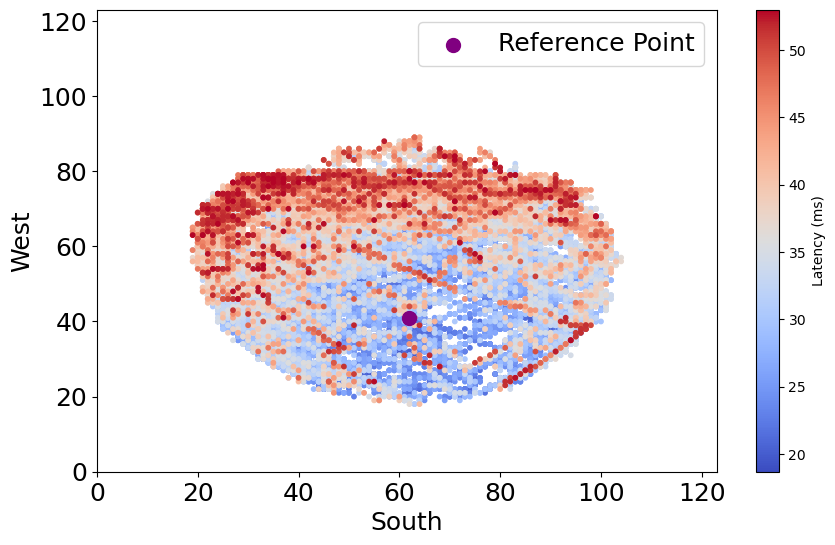

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV file
file_path = 'matched_satellite_data.csv'  # Update this path to your actual CSV file path
data = pd.read_csv(file_path)

# Convert the 'Timestamp' column to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Calculate the interquartile range (IQR) for PingTime
Q1 = data['PingTime'].quantile(0.25)
Q3 = data['PingTime'].quantile(0.75)
IQR = Q3 - Q1

print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"Interquartile Range (IQR): {IQR}")

# Filter out the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_data = data[(data['PingTime'] >= lower_bound) & (data['PingTime'] <= upper_bound)]

# Sort the filtered data by PingTime so that higher ping times are plotted on top
filtered_data = filtered_data.sort_values(by='PingTime')

# Plotting the points for the filtered dataset
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(filtered_data['X'], filtered_data['Y'], c=filtered_data['PingTime'], cmap='coolwarm', s=10)
plt.colorbar(sc, label='Latency (ms)')

# Highlight the specific point
tilt=27.3
ax.scatter(62, 62-(tilt/(80/62)), color='purple', s=100, label='Reference Point')

ax.set_xlabel('South', fontsize=18)
ax.set_ylabel('West', fontsize=18)
# ax.set_title('Latency Distribution in Trajectory Plot', fontsize=18)
ax.set_xlim(0, 123)
ax.set_ylim(0, 123)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=18)
plt.savefig("dis.eps",format='eps')
plt.show()


First few rows of the filtered dataset:
                  Timestamp   Y   X  Elevation    Azimuth   PingTime  \
0 2024-06-22 00:10:12+00:00  71  76  47.234009  25.186862  45.156716   
1 2024-06-22 00:10:13+00:00  71  76  47.234009  25.186862  41.251351   
2 2024-06-22 00:10:14+00:00  71  76  47.234009  25.186862  34.177143   
3 2024-06-22 00:10:15+00:00  71  77  46.664795  26.742437  34.498551   
4 2024-06-22 00:10:16+00:00  71  77  46.664795  26.742437  43.717143   

  Connected_Satellite    Distance  
0       STARLINK-3930  743.104689  
1       STARLINK-3930  744.184660  
2       STARLINK-3930  745.328107  
3       STARLINK-3930  746.534737  
4       STARLINK-3930  747.804244  

Summary statistics:
                  Y             X     Elevation       Azimuth      PingTime  \
count  52237.000000  52237.000000  52237.000000  52237.000000  52237.000000   
mean      62.245018     55.724257     48.388370    209.008551     37.166401   
std       14.429445     20.529583     12.060835    13

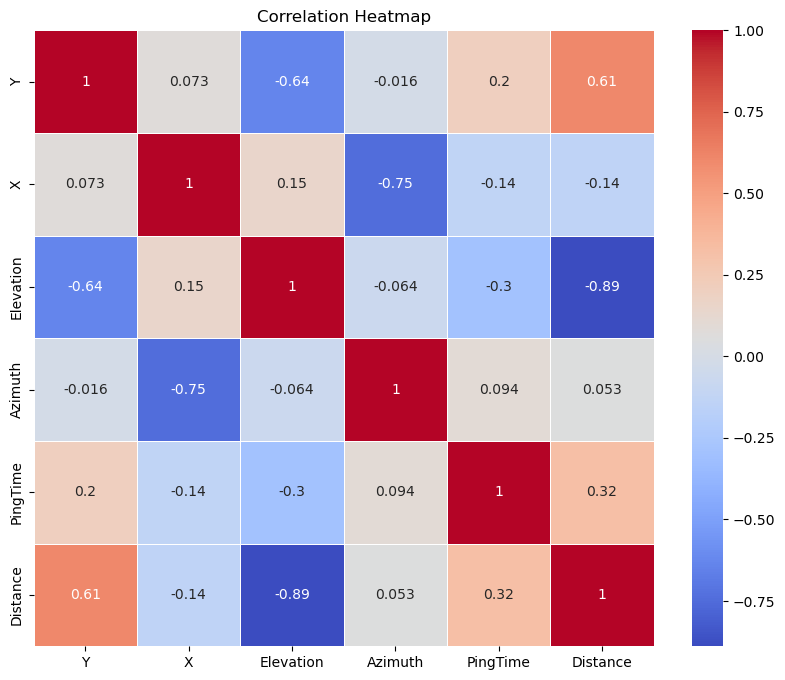

C:\Users\ALI\AppData\Local\Temp\ipykernel_10784\3563910133.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['IntervalStart'] = filtered_data['Timestamp'].apply(assign_interval)


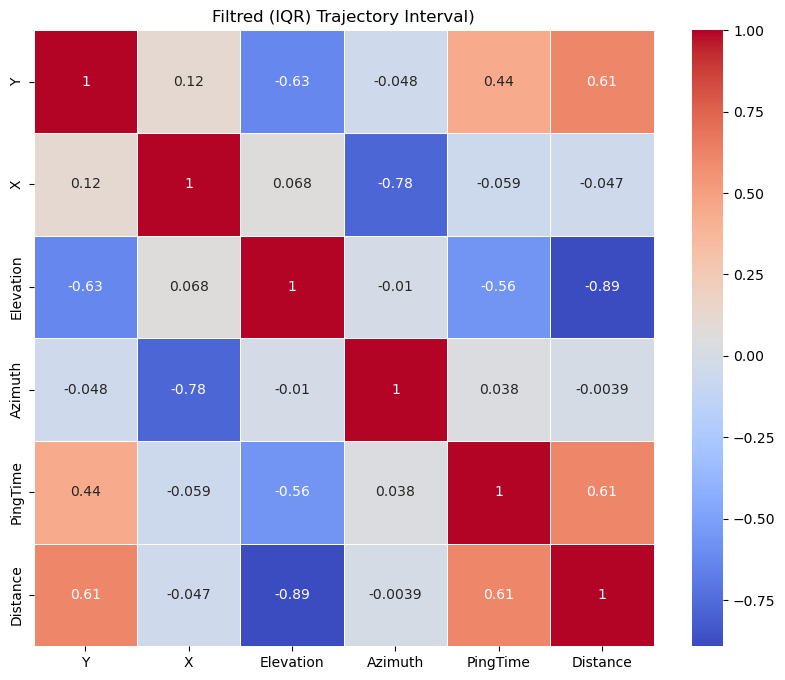

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'matched_satellite_data.csv'  # Update this with the correct file path
data = pd.read_csv(file_path)

# Convert Timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

print("First few rows of the filtered dataset:")
print(data.head())

# Summary statistics
print("\nSummary statistics:")
print(data.describe())

# Checking for missing values
print("\nMissing values in the dataset:")
print(data.isnull().sum())

# Correlation matrix (excluding non-numeric columns)
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

# Display correlation matrix
print("\nCorrelation matrix:")
print(corr_matrix)

# Plotting correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

def assign_interval(ts):
    if ts.second >= 12 and ts.second < 27:
        return ts - pd.to_timedelta(ts.second - 12, unit='s')
    elif ts.second >= 27 and ts.second < 42:
        return ts - pd.to_timedelta(ts.second - 27, unit='s')
    elif ts.second >= 42 and ts.second < 57:
        return ts - pd.to_timedelta(ts.second - 42, unit='s')
    else:
        return ts - pd.to_timedelta(ts.second - 57, unit='s')

# Apply the function to create interval start timestamps for the unfiltered data
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['IntervalStart'] = data['Timestamp'].apply(assign_interval)

# Group by interval start and calculate the mean for each interval, excluding non-numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
aggregated_data = data.groupby('IntervalStart')[numeric_columns].mean().reset_index()
aggregated_data = aggregated_data.drop(columns=['IntervalStart'])

# Calculate correlation matrix without filtering handover seconds but averaging intervals
corr_matrix_aggregated = aggregated_data.corr()


# Filter data based on the IQR of the latency (PingTime column)
Q1 = data['PingTime'].quantile(0.25)
Q3 = data['PingTime'].quantile(0.75)
IQR = Q3 - Q1

filtered_data = data[(data['PingTime'] >= (Q1 - 1.5 * IQR)) & (data['PingTime'] <= (Q3 + 1.5 * IQR))]

# Apply the interval function to create interval start timestamps for the filtered data
filtered_data['IntervalStart'] = filtered_data['Timestamp'].apply(assign_interval)

# Group by interval start and calculate the mean for each interval, excluding non-numeric columns
filtered_aggregated_data = filtered_data.groupby('IntervalStart')[numeric_columns].mean().reset_index()
filtered_aggregated_data = filtered_aggregated_data.drop(columns=['IntervalStart'])

# Calculate correlation matrix for the filtered and averaged intervals
corr_matrix_filtered_aggregated = filtered_aggregated_data.corr()

# Plotting correlation heatmap for filtered data with averaging intervals
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_filtered_aggregated, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Filtred (IQR) Trajectory Interval)')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


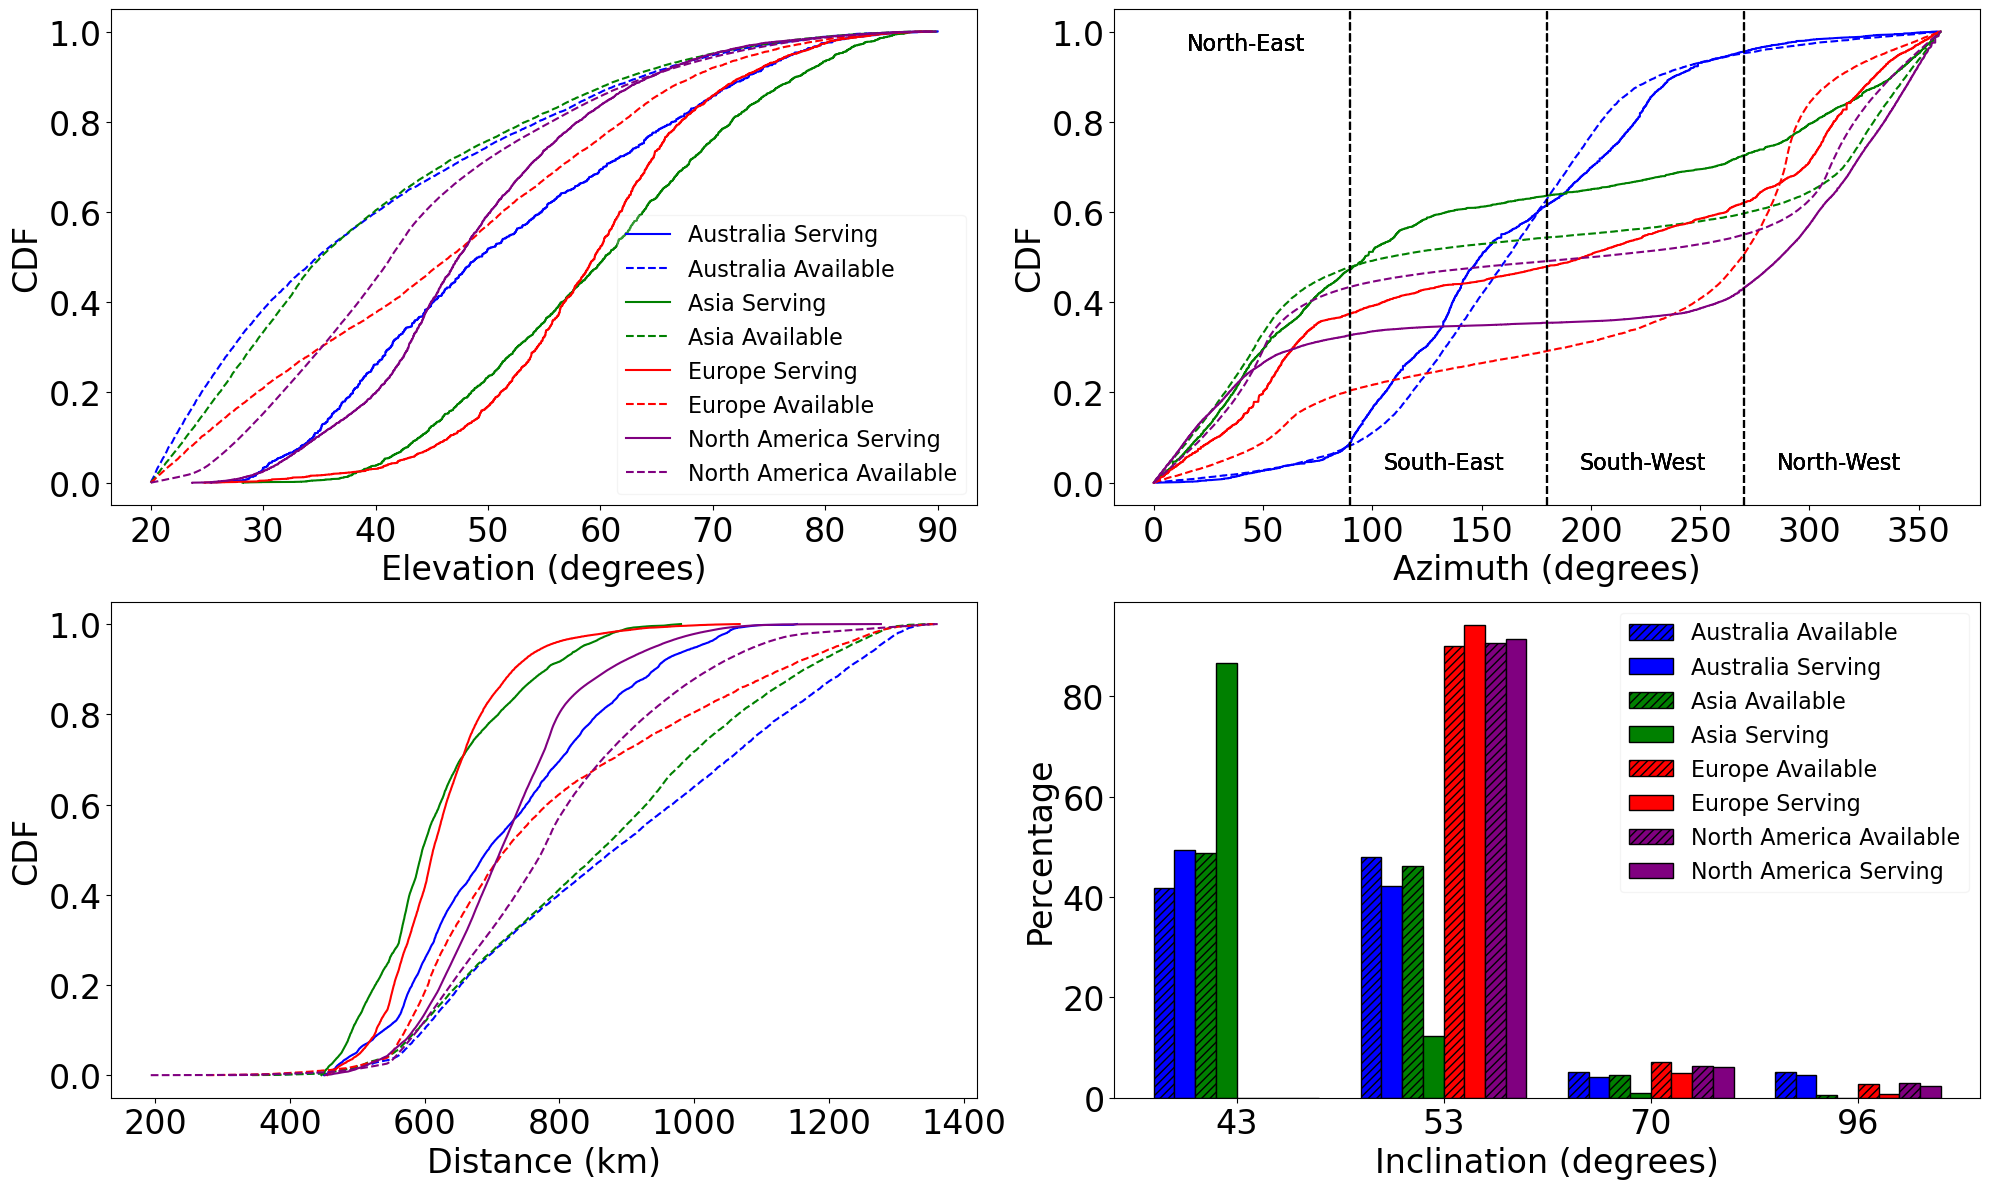

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from skyfield.api import load, EarthSatellite

def calculate_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

def adjust_azimuths(azimuths, adjustment):
    adjusted_azimuths = [(az + adjustment) % 360 for az in azimuths]
    return adjusted_azimuths

def categorize_inclinations(inclinations):
    categories = {'40-50': 0, '50-60': 0, '60-80': 0, '80-100': 0}
    for inc in inclinations:
        if 40 <= inc < 50:
            categories['40-50'] += 1
        elif 50 <= inc < 60:
            categories['50-60'] += 1
        elif 60 <= inc < 80:
            categories['60-80'] += 1
        elif 80 <= inc <= 100:
            categories['80-100'] += 1
    total = sum(categories.values())
    for key in categories:
        categories[key] = (categories[key] / total) * 100  # Convert to percentage
    return categories

def categorize_azimuths(azimuths):
    categories = {'North-East': 0, 'North-West': 0, 'South-East': 0, 'South-West': 0}
    for az in azimuths:
        if 0 <= az < 90:
            categories['North-East'] += 1
        elif 90 <= az < 180:
            categories['South-East'] += 1
        elif 180 <= az < 270:
            categories['South-West'] += 1
        elif 270 <= az < 360:
            categories['North-West'] += 1
    total = sum(categories.values())
    for key in categories:
        categories[key] = (categories[key] / total) * 100  # Convert to percentage
    return categories

def plot_cdfs_and_histograms(fov_data_dict, matched_data_dict):
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    colors = {'Australia': 'blue', 'Asia': 'green', 'Europe': 'red', 'North America': 'purple'}
    adjustments = {'Australia': 159, 'Asia': 8.8, 'Europe': -43, 'North America': -2.5}
    regions = list(fov_data_dict.keys())

    # Prepare data for inclination histograms
    incl_categories = ['40-50', '50-60', '60-80', '80-100']
    azimuth_categories = ['North-East', 'South-East', 'South-West', 'North-West']
    incl_fov_counts = {region: categorize_inclinations([sat['Inclination'] for entry in fov_data_dict[region] for sat in entry['Satellites']]) for region in regions}
    incl_matched_counts = {region: categorize_inclinations(matched_data_dict[region]['Inclination'].dropna()) for region in regions}

    bar_width = 0.1  # narrower bar width
    x = np.arange(len(incl_categories))  # the label locations

    for i, region in enumerate(regions):
        matched_data = matched_data_dict[region]
        
        # Prepare FOV data
        azimuths_fov = []
        elevations_fov = []
        distances_fov = []

        for entry in fov_data_dict[region]:
            for sat in entry['Satellites']:
                azimuths_fov.append(sat['Azimuth'])
                elevations_fov.append(sat['Elevation'])
                distances_fov.append(sat['Distance'])

        # Adjust azimuths
        azimuth_sorted_fov, azimuth_cdf_fov = calculate_cdf(azimuths_fov)
        elevation_sorted_fov, elevation_cdf_fov = calculate_cdf(elevations_fov)
        distance_sorted_fov, distance_cdf_fov = calculate_cdf(distances_fov)

        # Prepare matched data
        matched_azimuths = adjust_azimuths(matched_data['Azimuth'].dropna(), adjustments[region])
        matched_elevations = matched_data['Elevation'].dropna()
        matched_distances = matched_data['Distance'].dropna()

        azimuth_sorted_matched, azimuth_cdf_matched = calculate_cdf(matched_azimuths)
        elevation_sorted_matched, elevation_cdf_matched = calculate_cdf(matched_elevations)
        distance_sorted_matched, distance_cdf_matched = calculate_cdf(matched_distances)

        # Plot elevation
        axes[0, 0].plot(elevation_sorted_matched, elevation_cdf_matched, linestyle='-', color=colors[region], label=f'{region} Serving')
        axes[0, 0].plot(elevation_sorted_fov, elevation_cdf_fov, linestyle='--', color=colors[region], label=f'{region} Available')
        axes[0, 0].set_xlabel('Elevation (degrees)', fontsize=24)
        axes[0, 0].set_ylabel('CDF', fontsize=24)
        axes[0, 0].tick_params(axis='both', which='major', labelsize=24)
        axes[0, 0].legend(fontsize=16, framealpha=0.2)

        # Plot azimuth
        axes[0, 1].plot(azimuth_sorted_matched, azimuth_cdf_matched, linestyle='-', color=colors[region], label=f'{region} Serving')
        axes[0, 1].plot(azimuth_sorted_fov, azimuth_cdf_fov, linestyle='--', color=colors[region], label=f'{region} Available')
        axes[0, 1].set_xlabel('Azimuth (degrees)', fontsize=24)
        axes[0, 1].set_ylabel('CDF', fontsize=24)
        axes[0, 1].tick_params(axis='both', which='major', labelsize=24)

        axes[0, 1].text(0 + 15, 1, 'North-East', rotation=0, verticalalignment='top', fontsize=16, color='black')
        for azimuth, label in zip([90, 180, 270], azimuth_categories[1:]):
            axes[0, 1].axvline(x=azimuth, linestyle='--', color='black')
            axes[0, 1].text(azimuth + 15, 0.02, label, rotation=0, verticalalignment='bottom', fontsize=16, color='black')

        # Plot distance
        axes[1, 0].plot(distance_sorted_matched, distance_cdf_matched, linestyle='-', color=colors[region], label=f'{region} Serving')
        axes[1, 0].plot(distance_sorted_fov, distance_cdf_fov, linestyle='--', color=colors[region], label=f'{region} Available')
        axes[1, 0].set_xlabel('Distance (km)', fontsize=24)
        axes[1, 0].set_ylabel('CDF', fontsize=24)
        axes[1, 0].tick_params(axis='both', which='major', labelsize=24)

    # Plot inclination histogram
    bar_width = 0.1  # the width of the bars
    x = np.arange(len(incl_categories))  # the label locations

    for i, region in enumerate(regions):
        incl_fov_vals = [incl_fov_counts[region][cat] for cat in incl_categories]
        incl_matched_vals = [incl_matched_counts[region][cat] for cat in incl_categories]

        positions = x + i * bar_width * 2  # Adjust positions to prevent overlap
        axes[1, 1].bar(positions - bar_width / 2, incl_fov_vals, bar_width, label=f'{region} Available', color=colors[region], hatch='////', edgecolor='black')  # Denser hatch pattern
        axes[1, 1].bar(positions + bar_width / 2, incl_matched_vals, bar_width, label=f'{region} Serving', color=colors[region], edgecolor='black')  # No transparency, fully opaque

    # Set x-axis ticks
    positions_all = np.arange(len(incl_categories)) + bar_width * (len(regions) - 1)
    axes[1, 1].set_xticks(positions_all)
    incl_categories = ['43', '53', '70', '96']
    axes[1, 1].set_xticklabels(incl_categories)

    axes[1, 1].set_xlabel('Inclination (degrees)', fontsize=24)
    axes[1, 1].set_ylabel('Percentage', fontsize=24)
    axes[1, 1].tick_params(axis='both', which='major', labelsize=24)
    axes[1, 1].legend(fontsize=16, framealpha=0.2)

    plt.tight_layout()
    plt.savefig('CDFs_and_Histograms_All_Regions.eps', format='eps')
    plt.show()

# Load matched data
matched_bri = pd.read_csv('first_bri.csv')
matched_kna = pd.read_csv('first_kna.csv')
matched_ucl = pd.read_csv('first_ucl.csv')
matched_vic = pd.read_csv('first_vic.csv')

# Convert Timestamp to datetime
matched_bri['Timestamp'] = pd.to_datetime(matched_bri['Timestamp'])
matched_kna['Timestamp'] = pd.to_datetime(matched_kna['Timestamp'])
matched_ucl['Timestamp'] = pd.to_datetime(matched_ucl['Timestamp'])
matched_vic['Timestamp'] = pd.to_datetime(matched_vic['Timestamp'])

# Load fov_data from JSON files
with open('fov_data_bri.json', 'r') as file:
    fov_data_bri = json.load(file)

with open('fov_data_kna.json', 'r') as file:
    fov_data_kna = json.load(file)

with open('fov_data_ucl.json', 'r') as file:
    fov_data_ucl = json.load(file)

with open('fov_data_vic.json', 'r') as file:
    fov_data_vic = json.load(file)

# Load TLE data for inclination
tle_data_url = 'gp.php'
satellites = load.tle_file(tle_data_url)
inclinations = {sat.name: sat.model.inclo * 180.0 / np.pi for sat in satellites}

# Add inclination data to the matched dataframes
matched_bri['Inclination'] = matched_bri['Connected_Satellite'].map(inclinations)
matched_kna['Inclination'] = matched_kna['Connected_Satellite'].map(inclinations)
matched_ucl['Inclination'] = matched_ucl['Connected_Satellite'].map(inclinations)
matched_vic['Inclination'] = matched_vic['Connected_Satellite'].map(inclinations)

# Dictionary of data
fov_data_dict = {
    'Australia': fov_data_bri,
    'Asia': fov_data_kna,
    'Europe': fov_data_ucl,
    'North America': fov_data_vic
}

matched_data_dict = {
    'Australia': matched_bri,
    'Asia': matched_kna,
    'Europe': matched_ucl,
    'North America': matched_vic
}

# Plot CDFs and histograms for all regions
plot_cdfs_and_histograms(fov_data_dict, matched_data_dict)
